<a href="https://colab.research.google.com/github/maggiecrowner/DS4002-Project-2/blob/main/Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! git clone https://github.com/maggiecrowner/DS4002-Project-2.git

Cloning into 'DS4002-Project-2'...
remote: Enumerating objects: 36, done.
remote: Counting objects: 100% (36/36), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 36 (delta 10), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (36/36), 1.70 MiB | 5.34 MiB/s, done.
Resolving deltas: 100% (10/10), done.


###Preprocessing

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import numpy as np
df = pd.read_csv('/content/DS4002-Project-2/DATA/raw_temperature_data.csv').drop(columns=['Unnamed: 0', 'tmin'])
df['Date'] = pd.to_datetime(df['Date'])
df = df[(df['Date'].dt.year >= 1970) & (df['Date'].dt.year <= 2023)]
df.set_index('Date', inplace=True)
df_monthly = df.resample('ME').mean()
df_monthly = df_monthly.reset_index()
df_monthly['tmax_diff'] = df_monthly['tmax'].diff(12)
df_monthly.dropna(subset=['tmax_diff'], inplace=True)

### Analysis

*Examine new ACF/PACF plots for possible parameter values*

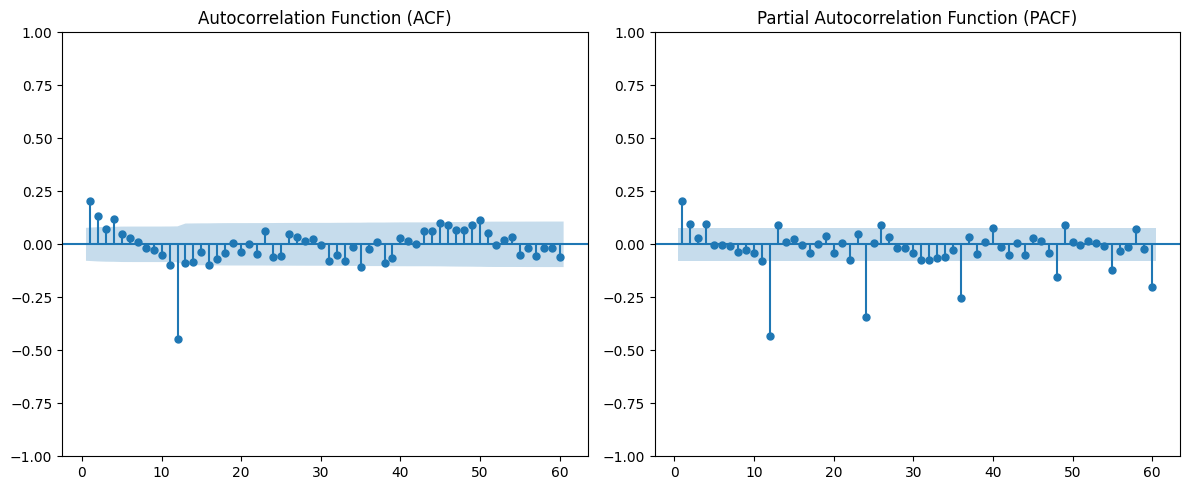

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# ACF Plot
plot_acf(df_monthly['tmax_diff'], ax=axes[0], lags=60, zero=False)
axes[0].set_title("Autocorrelation Function (ACF)")

# PACF Plot
plot_pacf(df_monthly['tmax_diff'], ax=axes[1], lags=60, method="ywm", zero=False)
axes[1].set_title("Partial Autocorrelation Function (PACF)")

plt.tight_layout()
plt.show()

**Candidate parameters:**

p: 2 or possibly 1

d: 0

q: 2

P: 0

D: 0

Q: 1

s: 12

*Grid search for optimal parameter values*

In [28]:
df_monthly['Date'] = pd.to_datetime(df_monthly['Date'])
df_monthly.set_index('Date', inplace=True)
train_data = df_monthly['tmax_diff']['1970-01-01':'2022-12-31']  # Training data from 1970 to 2022
test_data = df_monthly['tmax_diff']['2023-01-01':]  # Test data from 2023 onwards
train_exog = df_monthly['prcp']['1970-01-01':'2022-12-31']
test_exog = df_monthly['prcp']['2023-01-01':]

In [29]:
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from itertools import product
import warnings
warnings.filterwarnings("ignore")

def sarimax_grid_search(data, seasonal_period=12):
    # Define the parameter grid
    p = q = range(0, 3)  # Try AR and MA terms of 0, 1, 2
    d = range(0, 2)  # Try differencing from 0 to 1
    P = Q = range(0, 2)  # Seasonal AR and MA terms
    D = [0]  # Seasonal differencing
    seasonal = [seasonal_period]

    # Create the parameter grid
    param_grid = list(product(p, d, q, P, D, Q, seasonal))

    # Initialize variables to store the best model
    best_aic = np.inf
    best_order = None
    best_seasonal_order = None
    best_model = None

    # Perform grid search
    for param in param_grid:
        (p, d, q, P, D, Q, s) = param

        try:
            # Fit SARIMAX model
            model = SARIMAX(data,
                            order=(p, d, q),
                            seasonal_order=(P, D, Q, s),
                            exog=train_exog,
                            enforce_stationarity=False,
                            enforce_invertibility=False)
            result = model.fit(disp=False)

            # Check if the model's AIC is the lowest we've seen
            if result.aic < best_aic:
                best_aic = result.aic
                best_order = (p, d, q)
                best_seasonal_order = (P, D, Q, s)
                best_model = result
        except Exception as e:
            continue  # Skip models that fail to converge or fit

    print(f"Best Model AIC: {best_aic}")
    print(f"Best Model Order: {best_order}")
    print(f"Best Seasonal Order: {best_seasonal_order}")

    return best_model

best_sarimax_model = sarimax_grid_search(train_data)

Best Model AIC: 3171.86095735438
Best Model Order: (1, 0, 2)
Best Seasonal Order: (0, 0, 1, 12)


**Optimized parameters:**

p: 1

d: 0

q: 2

P: 0

D: 0

Q: 1

s: 12

This aligns with our previous guess, so we will proceed with the SARIMAX(1,0,2)*(0,0,1,12) model.

                               SARIMAX Results                                
Dep. Variable:              tmax_diff   No. Observations:                  624
Model:               SARIMAX(1, 0, 1)   Log Likelihood               -1807.503
Date:                Sun, 16 Mar 2025   AIC                           3623.006
Time:                        20:50:29   BIC                           3640.737
Sample:                    01-31-1971   HQIC                          3629.897
                         - 12-31-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
prcp          -2.6199      1.655     -1.583      0.113      -5.863       0.624
ar.L1          0.6908      0.104      6.638      0.000       0.487       0.895
ma.L1         -0.5079      0.123     -4.143      0.0

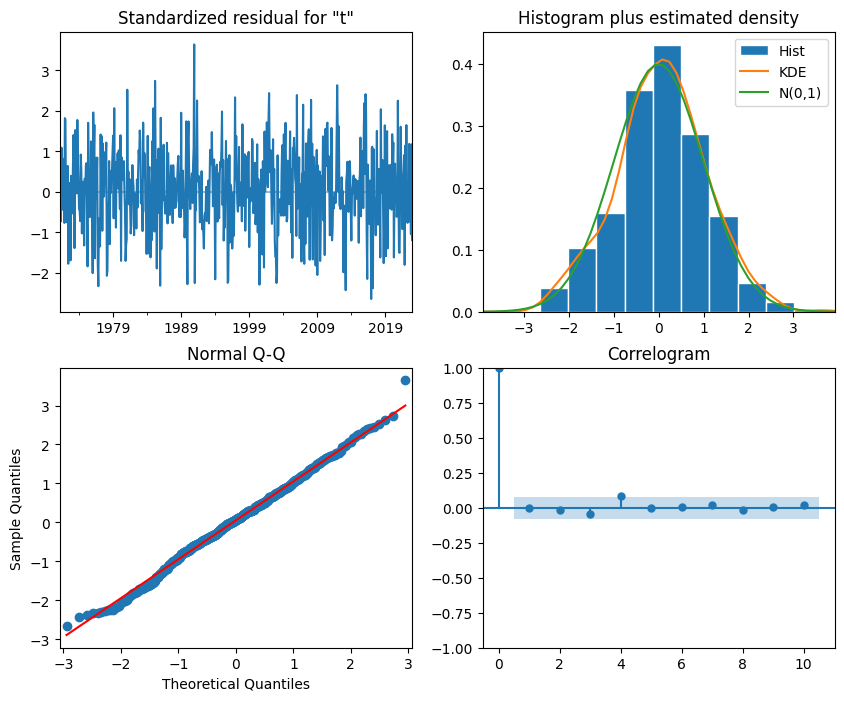

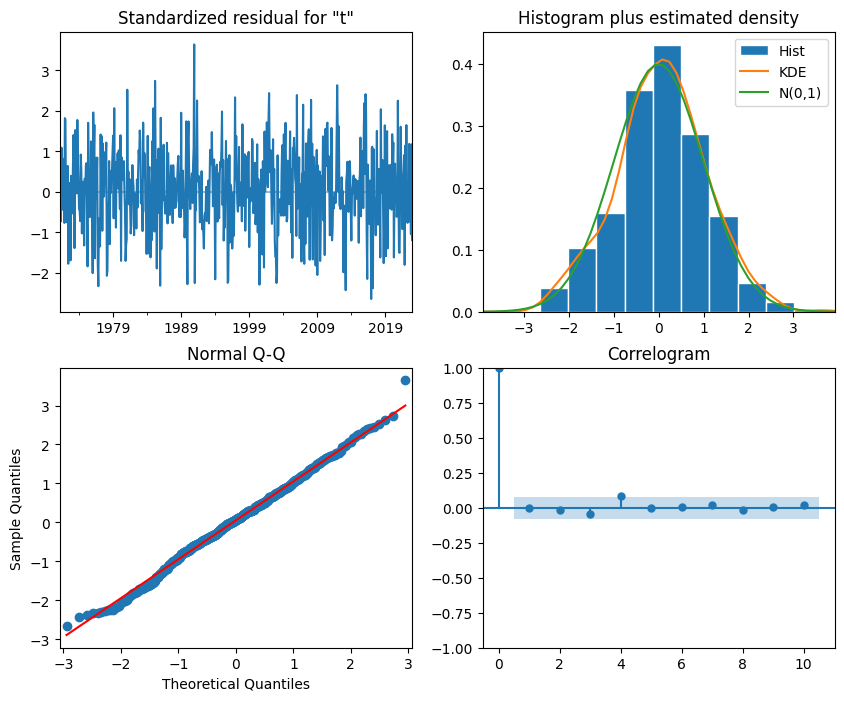

In [37]:
import statsmodels.stats.api as sms

# Fit the final SARIMAX model using the best parameters
final_model = sm.tsa.SARIMAX(train_data,
                             order=(1,0,1), # removed 2nd q component, wasn't significant
                             seasonal_order=(0,0,0,12), # removed Q component, wasn't significant
                             exog=train_exog, # kept prcp in even though it wasn't significant for now
                             enforce_stationarity=False,
                             enforce_invertibility=False)

# Fit the model and suppress the display of convergence output
final_result = final_model.fit(disp=False)

# Print the summary of the model fit
print(final_result.summary())

# Check the residuals and diagnostics
final_result.plot_diagnostics(figsize=(10, 8))
